In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from utils import set_seed, load_dataset, plot_feature_maps, plot_training_progress, evaluate_model
from transform import TensorAugment, ResizeBlur
from models import WDMClassifierMedium, WDMClassifierLarge
from sklearn.metrics import accuracy_score

In [2]:
cdm_model='IllustrisTNG'

cdm_file=f'/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/{cdm_model}/Maps_Mtot_{cdm_model}_LH_z=0.00.npy'
wdm_file='/n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy'

# Sample indices
all_indices = random.sample(range(720), 700)
random.shuffle(all_indices)



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = WDMClassifierLarge().to(device)
checkpoint = torch.load("best_cnn_model_blur_3_large.pt", map_location=device, weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

WDMClassifierLarge(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(512, 

In [13]:
sigmas = np.concatenate([np.linspace(0.0,0.5,10),np.linspace(0.25,0.29,10),np.linspace(0.29,0.35,10)])
sorted_idx = np.argsort(sigmas)
sigmas = sigmas[sorted_idx]
acc = []

In [14]:
for s in sigmas:
    # --- Define transform for this sigma ---
    blur_transform = TensorAugment(
        size=(256, 256),
        p_flip=0.0,
        p_rot=0.0,
        noise_std=0,
        blur_kernel=3,
        blur_sigma=s,
        apply_log=True,
        normalize=False
    )

    # --- Dataset and loader ---
    test_dataset = load_dataset(all_indices, transform=blur_transform, cdm_file=cdm_file, wdm_file=wdm_file)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, 
                             num_workers=1, pin_memory=True)

    # --- Inference ---
    all_preds, all_labels, features, softscores = [], [], [], []

    with torch.no_grad():
        for batch in test_loader:
            x, sigma_batch, y = batch
            x = x.to(device)
            sigma_batch = sigma_batch.to(device)
            y = y.to(device)

            # Forward through full model
            logits = model(x, sigma_batch).squeeze(1)  # New forward method handles everything
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            # Feature extraction (optional if you still want pooled features)
            feats = model.avgpool(model.features(x))
            feats = feats.view(feats.size(0), -1)

            # Store results
            features.append(feats.cpu())
            softscores.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # --- Aggregate and compute accuracy ---
    features = torch.cat(features, dim=0).numpy()
    softscores = np.array(softscores)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Blur sigma {s} Accuracy: {accuracy:.5f}")
    
    acc.append(accuracy)
    with open('acc_vs_sigma_large.txt', 'a') as file:
        file.write(f'{cdm_model} {s.item():.6f} {accuracy:.6f}\n')

# acc = np.asarray(acc)

Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
Loading WDM data from /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy...
WDM data shape: (15360, 256, 256)
Created dataset with 1400 samples
Blur sigma 0.0 Accuracy: 0.50000
Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
Loading WDM data from /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREAMS/Images/WDM/boxes/Maps_Mtot_IllustrisTNG_WDM_z=0.00.npy...
WDM data shape: (15360, 256, 256)
Created dataset with 1400 samples
Blur sigma 0.05555555555555555 Accuracy: 0.75500
Loading CDM data from /n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy...
CDM data shape: (15000, 256, 256)
Loading WDM data from /n/netscratch/iaifi_lab/Lab/ccuestalazaro/DREA

<>:63: SyntaxWarning: invalid escape sequence '\s'
<>:63: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_427715/3948367709.py:63: SyntaxWarning: invalid escape sequence '\s'
  ax.set_xlabel('Gaussian blur $\sigma$')
/tmp/ipykernel_427715/3948367709.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


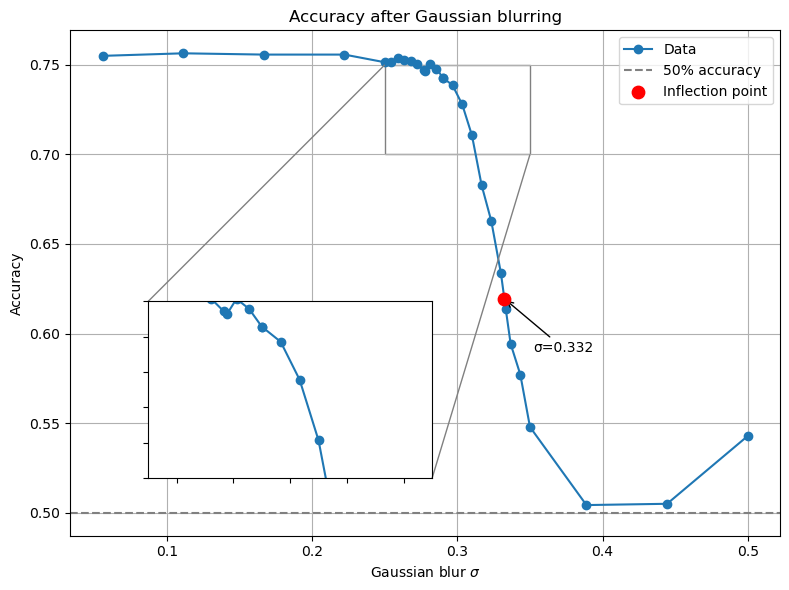

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

# --- Data ---
x = np.array(sigmas)
y = np.array(acc)

# --- Interpolation ---
spline = UnivariateSpline(x, y, s=1e-4)
x_dense = np.linspace(x.min(), x.max(), 1000)
y_dense = spline(x_dense)
d2y = spline.derivative(n=2)(x_dense)

# --- Inflection points ---
inflection_indices = np.where(np.diff(np.sign(d2y)))[0]
inflect_xs = x_dense[inflection_indices]
inflect_ys = y_dense[inflection_indices]

# Optionally select one for main highlight
if len(inflection_indices) >= 3:
    idx = inflection_indices[6]
    main_inflect_x = x_dense[idx]
    main_inflect_y = y_dense[idx]
else:
    main_inflect_x = main_inflect_y = None

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(8, 6))

# --- Main plot ---
ax.plot(x[1:], y[1:], marker='o', label='Data')
ax.axhline(0.5, color='gray', linestyle='dashed', label='50% accuracy')

# Highlight one chosen inflection
if main_inflect_x is not None:
    ax.scatter([main_inflect_x], [main_inflect_y], color='red', s=80, zorder=5, label='Inflection point')
    ax.annotate(f'σ={main_inflect_x:.3f}', xy=(main_inflect_x, main_inflect_y),
                xytext=(main_inflect_x + 0.02, main_inflect_y - 0.03),
                arrowprops=dict(facecolor='red', arrowstyle='->'))

# --- Inset zoom plot ---
axins = inset_axes(ax, width="50%", height="70%", loc='lower left', 
                   bbox_to_anchor=(0.1, 0.1, 0.8, 0.5), bbox_transform=ax.transAxes)

# Inset content
axins.plot(x, y, marker='o')

# Inset zoom limits
x1, x2 = 0.25, 0.35
y1, y2 = 0.7, 0.75
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Turn off tick labels for inset for cleaner look
axins.tick_params(labelleft=False, labelbottom=False)

# Mark zoom region
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# --- Final touches ---
ax.set_xlabel('Gaussian blur $\sigma$')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy after Gaussian blurring')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.savefig('blur.png')
plt.show()


In [35]:
data = []
with open('acc_vs_sigma_large.txt','r') as f:
    for line in f.readlines():
        data.append(line.strip().split(' '))

data=np.asarray(data)

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_292679/974171127.py:16: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Gaussian blur $\sigma$')


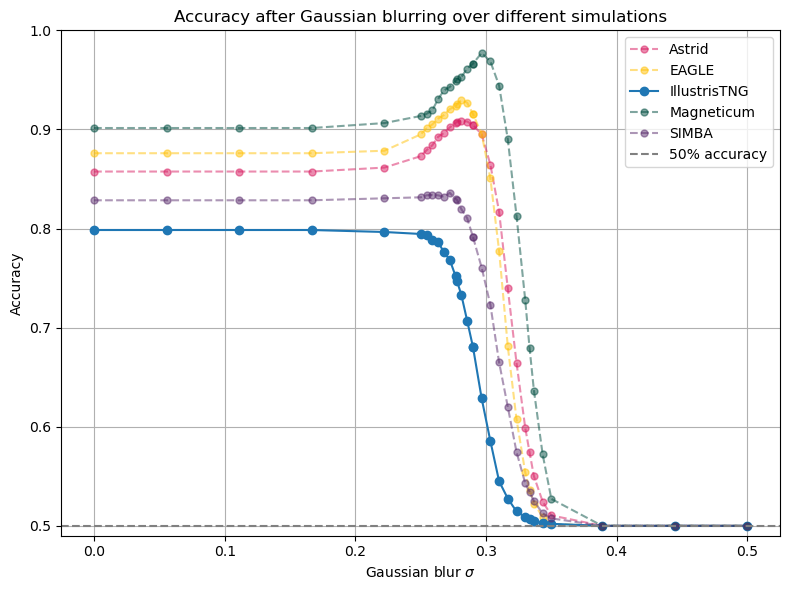

In [36]:
plt.subplots(figsize=(8, 6))

cs=['tab:orange','tab:green','tab:blue','tab:red','tab:purple']
cs=['#D81B60','#FFC107','tab:blue','#004D40','#5B2E6E']

for sim, c in zip(np.unique(data[:,0]),cs):
    d = data[np.where(sim==data[:,0]),1:][0].astype(float)
    if sim=='IllustrisTNG':
        plt.plot(d[:,0],d[:,1], marker='o',label=sim,linestyle='solid',color=c)
    else:
        plt.plot(d[:,0],d[:,1], marker='o',label=sim,ms=5,linestyle='dashed', alpha=0.5, color=c)

plt.axhline(0.5, color='gray', linestyle='dashed', label='50% accuracy')
plt.legend()
plt.ylim(0.49,1)
plt.xlabel('Gaussian blur $\sigma$')
plt.ylabel('Accuracy')
plt.title('Accuracy after Gaussian blurring over different simulations')
plt.grid('True')
plt.tight_layout()
plt.savefig('blur_sims.png')
plt.show()